In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/ML/AGAexons_features.csv", sep=",")

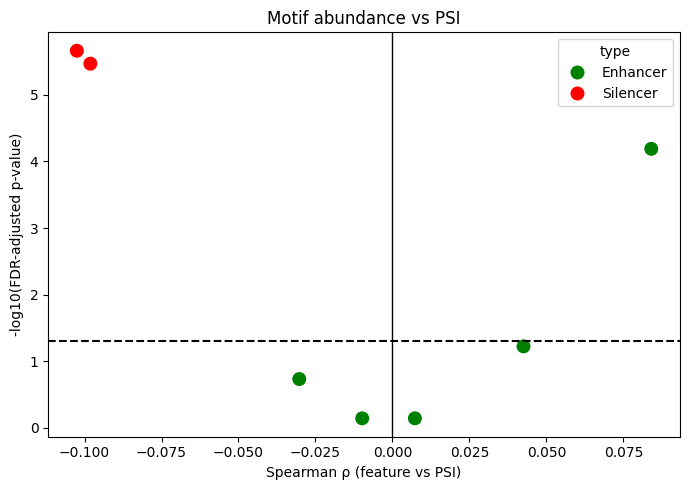

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Settings
# -----------------------------
features = [
    "SF2/ASF_mean_score",
    "SF2/ASF_IgM_BRCA1_mean_score",
    "SC35_mean_score",
    "SRp40_mean_score",
    "SRp55_mean_score",
    "FAS_hex2_density",
    "FAS_hex3_density"
]

enhancers = {
    "SF2/ASF_mean_score",
    "SF2/ASF_IgM_BRCA1_mean_score",
    "SC35_mean_score",
    "SRp40_mean_score",
    "SRp55_mean_score"
}

silencers = {"FAS_hex2_density", "FAS_hex3_density"}


# Compute correlations
results = []
for f in features:
    valid = df[[f, "PSI"]].dropna()
    rho, p = spearmanr(valid[f], valid["PSI"])
    results.append((f, rho, p))

corr_df = pd.DataFrame(results, columns=["feature", "rho", "p"])

# Benjamini–Hochberg FDR
pvals = corr_df["p"].values
order = np.argsort(pvals)
ranked = pvals[order]
q = ranked * len(pvals) / (np.arange(len(pvals)) + 1)
q = np.minimum.accumulate(q[::-1])[::-1]
corr_df["padj"] = q[np.argsort(order)]


# plot
corr_df["type"] = corr_df["feature"].apply(
    lambda x: "Enhancer" if x in enhancers else ("Silencer" if x in silencers else "Other")
)
corr_df["neglog10_padj"] = -np.log10(corr_df["padj"])

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=corr_df,
    x="rho",
    y="neglog10_padj",
    hue="type",
    palette={"Enhancer": "green", "Silencer": "red", "Other": "grey"},
    s=120
)

plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, color="black", linewidth=1)

plt.xlabel("Spearman ρ (feature vs PSI)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.title("Motif abundance vs PSI")
plt.tight_layout()
plt.show()
